# Бэтмен: Полиномы Лежандра

Автор: [Илья Ощепков](https://thegeodesy.com/)

В поисках интересных примеров для разложения в ряд по полиномам Лежандра, мне вспомнилось, что я встречал на просторах сети уравнение, описывающее логотип Бэтмена. И действительно, быстрый поиск привел к нужному результату. Довольно страшненькому, надо сказать, то есть как раз к тому, на котором хорошо показывать, почему аппроксимация порой изящнее исходного уравнения или функции, а также какие трудности при этом возникают.

## Функция Бэтмена

Итак, нас интересует математическая функция, которая описывала бы каким-то образом вот этот логотип Бэтмена, известного всем Тёмного рыцаря и грозы всех преступников Готэма.

<img src="batlogo.png" />

Автором уравнения является преподаватель математики J. Matthew Register, о чём он сам сообщает на [Quora](https://www.quora.com/Who-wrote-the-Batman-equation). Но особенно хорошее обсуждение и подробный разбор есть на [StackExchange](https://math.stackexchange.com/questions/54506/is-this-batman-equation-for-real). Всем заинтересованным в самой функции очень рекомендую туда заглянуть. В процессе раздумий, я наткнулся на очень похожий пост о разложении функции Бэтмена в ряд Фурье [здесь](https://www.enib.fr/~choqueuse/articles/signal_processing/batman_fourier.html), откуда многое пришлось позаимствовать. Наконец, сами формулы взяты [отсюда](https://www.desmos.com/calculator/dnzfajfpym).

Делаем сразу все необходимые импорты для наших изысканий.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)

from scipy.special import lpn
from scipy.integrate import quad

Функция Бэтмена, или правильнее, наверное, бэтфункция, является [кусочно-заданной](https://ru.wikipedia.org/wiki/%D0%9A%D1%83%D1%81%D0%BE%D1%87%D0%BD%D0%BE-%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%BD%D0%B0%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F) и к сожалению для нас не является однозначной, то есть одному значению $x$ соответствует два значения $y$. Но её можно разбить на две функции: одну для верхней части, а вторую для нижней части.

### Верхняя часть

Верхняя часть описывается чётной функцией $f_u$ с областью определения $-7 \leq x \leq 7$:

\begin{equation}
f_u(x)=\begin{cases}
2.25, &\mbox{если } 0\le |x| <0.5,\\
3|x|+0.75,&\mbox{если } 0.5\le |x|<0.75,\\ 9-8|x|,&\mbox{если } 0.75\le |x|<1,\\
1.5-0.5|x|-\dfrac{3\sqrt{10}}{7}\left(\sqrt{3-x^2+2|x|}- 2\right),& \mbox{если } 1\le |x|<3,\\
3\sqrt{1-\left(\frac{x}{7}\right)^2},&\mbox{если } 3\le |x| \le 7.\\
\end{cases}.
\end{equation}

In [2]:
def batman_upper(x):
    x = np.abs(x)
    if x > 7:
        return ValueError(
            'The Baxman equaxion is defined on -7 <= x <= 7')
    elif x < 0.5:
        return 2.25
    elif 0.5 <= x < 0.75:
        return 3 * x + 0.75
    elif 0.75 <= x < 1.0:
        return 9 - 8 * x
    elif 1 <= x < 3:
        return (1.5 - 0.5 * x - 3 * np.sqrt(10) / 7 * 
             (np.sqrt(3 - x**2 + 2 * x) - 2))
    elif 3 <= x <= 7:
        return 3 * np.sqrt(-(x / 7)**2 + 1)

### Нижняя часть

Нижняя часть логотипа также может быть описана чётной функцией $f_l$ с областью определения $-7 \leq x \leq 7$:

$$
f_l(t)=
\begin{cases}
\left|\dfrac{x}{2}\right|-\left(\dfrac{3 \sqrt{33} - 7}{112}\right) x^2+
\sqrt{1-\left(\left|\left|x\right| - 2\right|-1\right)^2}-3, &\text{если } 0\le |x|<4,\\
-3\sqrt{-\left(\frac{x}{7}\right)^2+1},&\text{если } 4\le |x| \le 7.
\end{cases}.
$$

In [3]:
def batman_lower(x):
    x = np.abs(x)
    if x > 7:
        return ValueError(
            'The Batman equation is defined on -7 <= t <= 7')
    elif 0 <= x < 4:
        return (np.abs(x / 2) - (3*np.sqrt(33) - 7) / 112 * x**2 +
             np.sqrt(1 - (np.abs(x - 2) - 1)**2) - 3)
    elif 4 <= x <= 7 :
        return -3 * np.sqrt(-(x / 7)**2 + 1)

### Полная функция и её график

Таким образом, мы получили довольно сложную кусочно-заданную бэтфункцию $f$, состоящую из двух частей:

$$
f \left( x \right) = 
\left\{\begin{array}{l}
f_u \left( x \right) \\
f_l \left( x \right)
\end{array}\right\}.
$$

Она, очевидно, является чётной. Область определения и область значений легко установить исходя из того, что в качестве исходного уравнения брался эллипс

$$
\left( \dfrac{x}{7} \right)^{2} + \left( \dfrac{y}{3} \right)^{2} = 1
$$

с большой полуосью $a = 7$ и малой полуосью $b = 3$, то есть весь логотип лежит внутри этого эллипса, поэтому

$$x \in \left[ -7, 7 \right],\quad y \in \left[-3, 3\right].$$

Теперь рисуем полный график бэтфункции. Мы берем шаг $0.01$, при котором мы не потеряем информацию при отображении.

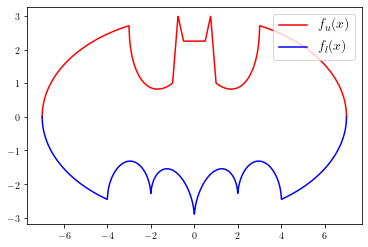

In [4]:
x = np.linspace(-7, 7, 700*2)
y_upper = np.array([batman_upper(xi) for xi in x])
y_lower = np.array([batman_lower(xi) for xi in x])

plt.plot(x, y_upper, 'r', label="$f_u (x)$")
plt.plot(x, y_lower, 'b', label="$f_l (x)$")

plt.legend(loc='upper right', fontsize=14)

Выглядит очень достоверно. Нам понадобилось $2\times 1400$ точек. 

Мы замечаем определённые сложности. Уши летучей мыши, а также её нижняя часть имеют острые углы, а потому сглаживание любой аппроксимирующей функцией потребует намного больше членов, которые понадобятся именно на эти места.

## Разложение бэтфункции в ряд Лежандра

В этом разделе мы попробуем разложить бэтфункцию в ряд Лежандра, а точнее в два ряда, поскольку результирующая функция не является однозначной. Разложение в общем виде можно записать так 

$$
f \left( x \right) = 
\left\{\begin{array}{l}
f_u \left( x \right) \\
f_l \left( x \right) 
\end{array}\right\} =
\sum\limits_{n=0}^{\infty} 
\left\{\begin{array}{l}
u_n \\ l_n
\end{array}\right\}
P_n \left( x \right) \approx
\sum\limits_{n=0}^{N} 
\left\{\begin{array}{l}
u_n \\ l_n
\end{array}\right\}
P_n \left( x \right),
$$

где $u_n$ и $l_n$ являются коэффициентами при полиноме Лежандра $P_n$ стпени $n$ в разложении верхней и нижней части бэтфункции соответственно, $N$ - максимальная степень разложения, обшая для верхней и нижней части бэтфункции. Очевидно, что число коэффициентов будет равно $2 \times \left(N + 1\right)$.

Коэффициенты разложения можно найти по известному правилу

$$
\left\{\begin{array}{l}
u_n \\ l_n
\end{array}\right\} =  
\dfrac{2n + 1}{2} \int\limits_{-1}^{+1} \left\{\begin{array}{l}
f_u \left( x \right) \\
f_l \left( x \right) 
\end{array}\right\} P_n \left( x \right) dx,
$$

однако поскольку функции $f_u$ и $f_l$ чётные, то выражение можно немного упростить

$$
\left\{\begin{array}{l}
u_n \\ l_n
\end{array}\right\} =  
\left({2n + 1}\right) \int\limits_{0}^{1} \left\{\begin{array}{l}
f_u \left( x \right) \\
f_l \left( x \right) 
\end{array}\right\} P_n \left( x \right) dx.
$$

Полиномы Лежандра ортогональны на отрезке $\left[ -1, 1 \right]$, а бэтфункция имеет область определения $\left[ -7, 7 \right]$. Следовательно, для аппроксимации всей кривой, нам нужно нормализовать $x$ в пределах $\left[ -1, 1 \right]$, что можно сделать так

$$
x' = 2 \dfrac{x - \min(x)}{\max(x) - \min(x)} - 1 = \dfrac{x}{7},
$$

где $x'$ теперь лежит в пределах $\left[ -1, 1 \right]$, поэтому

$$
\left\{\begin{array}{l}
u_n \\ l_n
\end{array}\right\} =  
\left({2n + 1}\right) \int\limits_{0}^{1} \left\{\begin{array}{l}
f_u \left( 7x' \right) \\
f_l \left( 7x' \right) 
\end{array}\right\} P_n \left( x' \right) dx'.
$$

Таким образом, мы будем искать коэффициенты от $\frac{1}{7} x$, что потом нужно будет учесть.

Вычислять интеграл мы будем численно с помощью функции `scipy.integrate.quad`, а входящие в интеграл полиномы Лежандра получим из функции `scipy.special.lpn`.


In [5]:
def batman2legendre(n_max):
    """Expand Batman function in Legendre series.
    
    """
    ul = np.zeros((2, n_max + 1))
    
    func = [batman_upper, batman_lower]
    
    args = {'a' : 0, 'b' : 1, 'epsabs' : 1e-6,
           'epsrel' : 1e-4, 'limit' : int(1e4)}
    
    for n in np.arange(0, n_max + 1, 2):
        for i, fi in enumerate(func):
            ul[i, n] = quad(lambda x: fi(7*x) * lpn(n, x)[0][-1], **args)[0]
        ul[:,n] *= (2*n + 1)
    return ul

Посмотрим, насколько хорошо работает наша аппроксимация. Для этого нарисуем графки для разных степеней $N$.

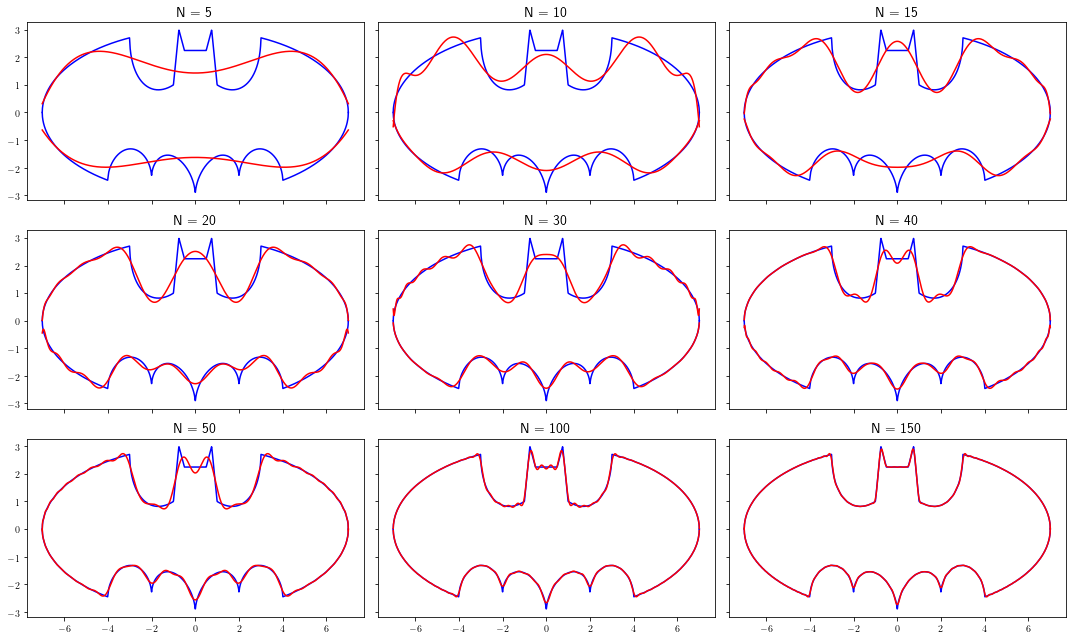

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15, 9),
                         sharey=True, sharex=True)
axes = axes.flatten()

degrees = [5, 10, 15, 20, 30, 40, 50, 100, 150]
for i, n in enumerate(degrees):
    batcoef = np.around(batman2legendre(n),3)
    batleg = np.polynomial.legendre.legval(x / 7, batcoef.T)
    axes[i].plot(x, y_upper, 'b')
    axes[i].plot(x, y_lower, 'b')
    
    axes[i].plot(x, batleg[0], 'r')
    axes[i].plot(x, batleg[1], 'r')
    
    axes[i].set_title('N = {}'.format(n), fontsize=14)

plt.tight_layout()

Мы наблюдаем, что при степенях $n > 100$ аппроксимация практически совпадает с исходной функцией. Однако, если присмотреться, то всё еще остаются проблемные места, в основном на границах кусков, что легко объяснимо. 

Экспериментальным путём можно найти, что при $N = 800$ аппроксимация становится практически безупречной. Это конечно большое число, однако информации становится всё равно меньше. Вместо $2 \times 1400 = 2800$ исходных точек мы получили $\frac{1}{2}(2 \times 802) = 802$ коэффициента. Дробь  $\frac{1}{2}$ возникает из-за того, что у нас только чётные коэффициенты. Надо отметить, что разложение в ряд Фурье, ссылка на который была дана в самом начале, сходится быстрее и можно получить аппроксимацию с меньшим числом коэффициентов.

Полученные коэффициенты можно сохранить, например в текстовый файл и далее использовать повторно, когда нужно будет в очередной раз позвать Бэтмена на помощь.

Что же в итоге мы получили? Нарисуем наш результат по разложению бэтфункции в два ряда по полиномам Лежандра до $N = 800$.

(-7.7, 7.7, -3.1784442295114523, 3.271195971069971)

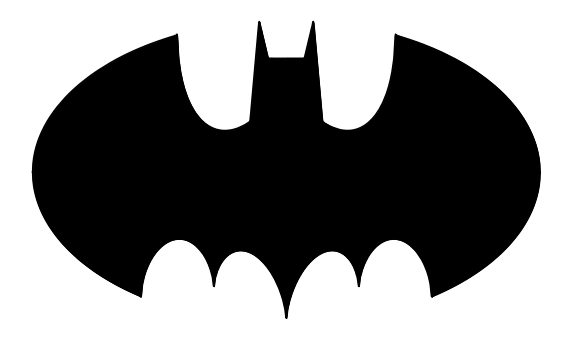

In [7]:
fig = plt.figure(figsize=(10, 6))

n_max = 800

batcoef = np.around(batman2legendre(n_max), 3)
batleg  = np.polynomial.legendre.legval(x / 7, batcoef.T)

plt.plot(x, batleg[0], 'k')
plt.plot(x, batleg[1], 'k')
plt.fill_between(x, batleg[0], batleg[1], color='k')
plt.axis('off')

<div style="text-align:center;" class="h3">Можно звать Бэтмена!</div>